# Clasificacion Automatica de Tickets con NLP


---


### Integrantes
* Villegas Jose Antonio 
* Yucra Wilmer
* Campos Juana

## Descripcion del Problema 

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling 

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [ ]:
## SpaCy and en_core_web_sm installation
!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importando las librerias necesarias

In [ ]:
import json
import numpy as np
import pandas as pd
import re, string

# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem import WordNetLemmatizer

# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [ ]:
# Opening JSON file

jsonFile = "/content/drive/MyDrive/Datasets/complaints.json"# Write the path to your data file and load it 

# returns JSON object as  
# a dictionary 
import json
with open(jsonFile) as f:
  data = json.load(f)
df=pd.json_normalize(data)

In [ ]:
#Get df shape
print(df.shape)

(78313, 22)


## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
#print the column names
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


* En el dataset observamos la columna **_source.complaint_what_happened ** que es la que nos interesa para realizar el analisis

In [ ]:
#Nombres de las Columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
#Assign new column names-
df.rename(columns={'_score': 'score', '_source.tags': 'source_tags', '_source.zip_code': 'zip_code'
, '_source.complaint_id': 'complaint_id', '_source.issue': 'issue'
, '_source.date_received': 'date_received', '_source.complaint_what_happened': 'complaint'}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   score                              78313 non-null  float64
 4   source_tags                        10900 non-null  object 
 5   zip_code                           71556 non-null  object 
 6   complaint_id                       78313 non-null  object 
 7   issue                              78313 non-null  object 
 8   date_received                      78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
#Assign nan in place of blanks in the complaints column
df['complaint'] = df['complaint'].replace('', np.nan)

In [ ]:
#Remove all rows where complaints column is nan
df = df[df['complaint'].notna()]

In [ ]:
#Print df columns , rows
df.shape

(21072, 22)

* Al quitar los nulls nos queda un dataset con 21072 filas

## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Hacer que l texto sea solo minusculas
* Sacar corchetes del texto
* Sacar la puntuacion
* Sacar numeros de las palabras

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lematizar el texto
* Extraer los tags POS deel texto lematizado.


In [ ]:
#function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
#1. make text lower case
df['complaint'] = df['complaint'].str.lower()

#2. Remove text in square brackets (using regex)
df['complaint'] = df['complaint'].str.replace(r'\[.*\]', '')
df['complaint'].head(5)

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in xx/xx/2018 and...
10    chase card was reported on xx/xx/2019. however...
11    on xx/xx/2018, while trying to book a xxxx  xx...
14    my grand son give me check for {$1600.00} i de...
Name: complaint, dtype: object

In [ ]:
df['complaint'].head(3)

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in xx/xx/2018 and...
10    chase card was reported on xx/xx/2019. however...
Name: complaint, dtype: object

In [ ]:
#3. Remove punctuation
df['complaint'] = df['complaint'].apply(remove_punctuation)

In [ ]:
df['complaint'].head(3)

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in xxxx2018 and w...
10    chase card was reported on xxxx2019 however fr...
Name: complaint, dtype: object

In [ ]:
# Remove words containing numbers
df['complaint'] = df['complaint'].apply(lambda x: re.sub(r'\w*\d\w*', '', x))

In [ ]:
df['complaint'].head(3)

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in  and was told ...
10    chase card was reported on  however fraudulent...
Name: complaint, dtype: object

In [ ]:
# Write your function to Lemmatize the texts
#instantiate lematizer
lemmatizer = WordNetLemmatizer()


In [ ]:
def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer()
  tokens = nltk.word_tokenize(text)
  #lematized_tokens = ' '.join([lemmatize_word(word) for word in tokens])# 
  lematized_tokens=[lemmatizer.lemmatize(token) for token in tokens]
  return lematized_tokens # Lemmatize the word without a part of speech

In [ ]:
# create lematized colum l_complaint 
df['l_complaint'] = df['complaint'].apply(lambda x: lemmatize_text(x))

In [ ]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint','l_complaint']]

In [ ]:
df_clean.head(5)

,complaint,l_complaint
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,..."
2,i upgraded my xxxx xxxx card in and was told ...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w..."
10,chase card was reported on however fraudulent...,"[chase, card, wa, reported, on, however, fraud..."
11,on while trying to book a xxxx xxxx ticket ...,"[on, while, trying, to, book, a, xxxx, xxxx, t..."
14,my grand son give me check for i deposit it i...,"[my, grand, son, give, me, check, for, i, depo..."


In [ ]:
#Write your function to extract the POS tags 
# Define a function to get the WordNet part of speech from a part of speech tag
nlp = spacy.load("en_core_web_sm")

def pos_tag(tag):
    pos_tags = nltk.pos_tag(tag)
    text = ""
    for element in pos_tags:
      if element[1] == "NN":
        text = " " +element[0]+text
    return text
    


In [ ]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean['l_complaint'].apply(lambda x:pos_tag(x) ) 

In [ ]:
df_clean["complaint_POS_removed"].head()

1      help advance account chase consumer informati...
2      agent recording xxxx consent xxxxxxxx date ac...
10     applicant identity credit service consent ide...
11     error consent i application report credit inf...
14     chase number claim number check date time cou...
Name: complaint_POS_removed, dtype: object

In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,l_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...",help advance account chase consumer informati...
2,i upgraded my xxxx xxxx card in and was told ...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...",agent recording xxxx consent xxxxxxxx date ac...
10,chase card was reported on however fraudulent...,"[chase, card, wa, reported, on, however, fraud...",applicant identity credit service consent ide...
11,on while trying to book a xxxx xxxx ticket ...,"[on, while, trying, to, book, a, xxxx, xxxx, t...",error consent i application report credit inf...
14,my grand son give me check for i deposit it i...,"[my, grand, son, give, me, check, for, i, depo...",chase number claim number check date time cou...
...,...,...,...
78303,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ...",charge airline credit enrollment credit hotel...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,"[on, wednesday, xxxxxxxx, i, called, chas, my,...",fraudulent i status claim stating email call ...
78310,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...",i i extent i risk action recourse chase mogul...
78311,i have had flawless credit for yrs ive had ch...,"[i, have, had, flawless, credit, for, yr, ive,...",sum lump card credit person i pmt min card sl...


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

In [ ]:
df_clean["length"] = df_clean["complaint_POS_removed"].apply(lambda x: len(x))

df_clean

,complaint,l_complaint,complaint_POS_removed,length
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...",help advance account chase consumer informati...,154
2,i upgraded my xxxx xxxx card in and was told ...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...",agent recording xxxx consent xxxxxxxx date ac...,104
10,chase card was reported on however fraudulent...,"[chase, card, wa, reported, on, however, fraud...",applicant identity credit service consent ide...,71
11,on while trying to book a xxxx xxxx ticket ...,"[on, while, trying, to, book, a, xxxx, xxxx, t...",error consent i application report credit inf...,435
14,my grand son give me check for i deposit it i...,"[my, grand, son, give, me, check, for, i, depo...",chase number claim number check date time cou...,171
...,...,...,...,...
78303,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ...",charge airline credit enrollment credit hotel...,235
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,"[on, wednesday, xxxxxxxx, i, called, chas, my,...",fraudulent i status claim stating email call ...,683
78310,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...",i i extent i risk action recourse chase mogul...,708
78311,i have had flawless credit for yrs ive had ch...,"[i, have, had, flawless, credit, for, yr, ive,...",sum lump card credit person i pmt min card sl...,511


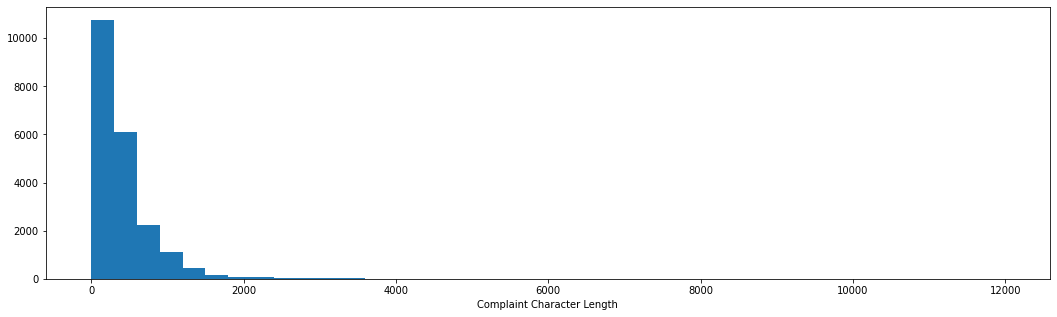

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length 
plt.figure(figsize=(18,5))
plt.hist(df_clean.length, bins=40)
plt.xlabel("Complaint Character Length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stop = set(stopwords.words('english'))

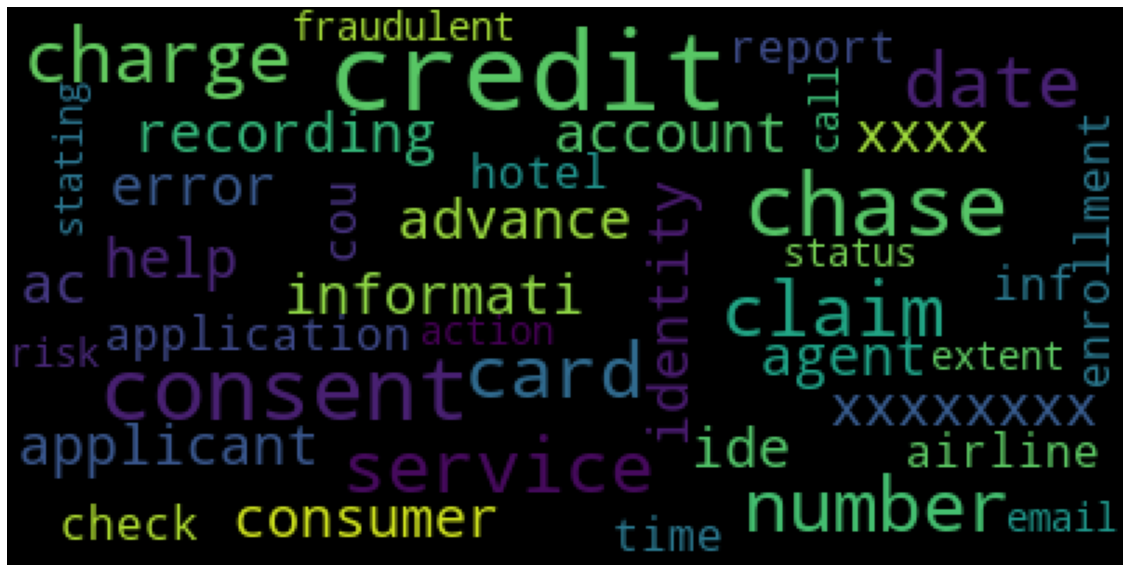

In [ ]:
wordcloud = WordCloud(stopwords=stop,max_words=40, 
                      max_font_size=40, random_state=42).generate(str(df_clean['complaint_POS_removed']))
fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

#unigram = ngrams(tokens,1)
#print(list(unigram)[:30])

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df_clean['Complaint_clean'].values.astype('U'), 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

In [ ]:
#Print the top 10 words in the unigram frequency
df2.head(10)

,unigram,count
0,chase,51048
1,account,47615
2,xxxx,38349
3,credit,33081
4,wa,32970
5,card,29568
6,bank,28212
7,payment,21142
8,time,16022
9,day,12954


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
#bigram = ngrams(tokens, 2)
#print(list(bigram)[:30])

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

In [ ]:
#Print the top 10 words in the bigram frequency
df3.head(10)

,bigram,count
0,card credit,12827
1,xxxx xxxx,4231
2,report credit,3878
3,credit chase,3126
4,service customer,3084
5,account chase,3024
6,wa account,2935
7,account bank,2870
8,chase account,2866
9,bank chase,2843


In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
#trigram = ngrams(tokens, 3)
#print(list(trigram)[:30])

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Top 30 trigrams by frequency among all the complaints
common_words = get_top_n_trigram(df_clean['Complaint_clean'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [ ]:
#Print the top 10 words in the trigram frequency
df4.head(10)

,trigram,count
0,card credit chase,2130
1,account card credit,1075
2,company card credit,996
3,chase card credit,715
4,report credit inquiry,517
5,credit card credit,506
6,xxxx xxxx xxxx,450
7,card credit account,420
8,card credit bank,393
9,agency reporting credit,388


## Los detalles personales han sido cambiados por xxxxx. Ahora hay que deshacernos de ellos porque ya no nos sirven

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint,l_complaint,complaint_POS_removed,length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...",help advance account chase consumer informati...,154,help advance account chase consumer informati...
2,i upgraded my xxxx xxxx card in and was told ...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...",agent recording xxxx consent xxxxxxxx date ac...,104,agent recording consent date account order ...
10,chase card was reported on however fraudulent...,"[chase, card, wa, reported, on, however, fraud...",applicant identity credit service consent ide...,71,applicant identity credit service consent ide...
11,on while trying to book a xxxx xxxx ticket ...,"[on, while, trying, to, book, a, xxxx, xxxx, t...",error consent i application report credit inf...,435,error consent i application report credit inf...
14,my grand son give me check for i deposit it i...,"[my, grand, son, give, me, check, for, i, depo...",chase number claim number check date time cou...,171,chase number claim number check date time cou...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ...",charge airline credit enrollment credit hotel...,235,charge airline credit enrollment credit hotel...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,"[on, wednesday, xxxxxxxx, i, called, chas, my,...",fraudulent i status claim stating email call ...,683,fraudulent i status claim stating email call ...
78310,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...",i i extent i risk action recourse chase mogul...,708,i i extent i risk action recourse chase mogul...
78311,i have had flawless credit for yrs ive had ch...,"[i, have, had, flawless, credit, for, yr, ive,...",sum lump card credit person i pmt min card sl...,511,sum lump card credit person i pmt min card sl...


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
# Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean)
#words_set = vectorizer.get_feature_names()
#print(words_set)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

6965

In [ ]:
#wtfidf=nmf_model.fit_transform(tfidf)
#htfidf= nmf_model.components_

In [ ]:
#tfidfmaintopics = np.argmax(wtfidf, axis=1)
#wtfidf = pd.DataFrame(wtfidf, columns=["Topic "+str(i) for i in range(1,6)])
#wtfidf["NMF-MainTopic"]=tfidfmaintopics

In [ ]:
#def print_top_words(model, feature_names, n_top_words):
#    for index, topic in enumerate(model.components_):
#        message = "\nTopic #{}:".format(index)
#        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
#        print(message)
#        print("="*70)

In [ ]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'\033[1mTHE TOP 15 WORDS FOR TOPIC #{index + 1}', '\033[0m')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#tf_feature_names = vectorizer.get_feature_names()
#print_top_words(nmf_model, tf_feature_names, 15)

THE TOP 15 WORDS FOR TOPIC #1 
['claim', 'checking', 'business', 'number', 'transaction', 'day', 'branch', 'deposit', 'wa', 'fund', 'chase', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #2 
['company', 'claim', 'time', 'fee', 'merchant', 'service', 'fraud', 'purchase', 'transaction', 'dispute', 'wa', 'credit', 'chase', 'charge', 'card']


THE TOP 15 WORDS FOR TOPIC #3 
['error', 'year', 'account', 'chase', 'credit', 'auto', 'date', 'time', 'day', 'wa', 'statement', 'month', 'fee', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #4 
['chase', 'identity', 'application', 'limit', 'information', 'reporting', 'debt', 'company', 'bureau', 'score', 'account', 'card', 'inquiry', 'report', 'credit']


THE TOP 15 WORDS FOR TOPIC #5 
['house', 'bank', 'foreclosure', 'document', 'time', 'rate', 'letter', 'wa', 'year', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']




In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

#doc_topic_df = pd.DataFrame(wtfidf, columns=['T1', 'T2', 'T3','T4','T5'])
#doc_topic_df

array([0, 1, 3, ..., 1, 2, 2])

In [ ]:
topic_results.shape

(21072, 5)

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis = 1)

df_clean['Topic']

1        0
2        1
10       3
11       3
14       0
        ..
78303    1
78309    1
78310    1
78311    2
78312    2
Name: Topic, Length: 21072, dtype: int64

In [ ]:
df_clean

,complaint,l_complaint,complaint_POS_removed,length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...",help advance account chase consumer informati...,154,help advance account chase consumer informati...,0
2,i upgraded my xxxx xxxx card in and was told ...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...",agent recording xxxx consent xxxxxxxx date ac...,104,agent recording consent date account order ...,1
10,chase card was reported on however fraudulent...,"[chase, card, wa, reported, on, however, fraud...",applicant identity credit service consent ide...,71,applicant identity credit service consent ide...,3
11,on while trying to book a xxxx xxxx ticket ...,"[on, while, trying, to, book, a, xxxx, xxxx, t...",error consent i application report credit inf...,435,error consent i application report credit inf...,3
14,my grand son give me check for i deposit it i...,"[my, grand, son, give, me, check, for, i, depo...",chase number claim number check date time cou...,171,chase number claim number check date time cou...,0
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ...",charge airline credit enrollment credit hotel...,235,charge airline credit enrollment credit hotel...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,"[on, wednesday, xxxxxxxx, i, called, chas, my,...",fraudulent i status claim stating email call ...,683,fraudulent i status claim stating email call ...,1
78310,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...",i i extent i risk action recourse chase mogul...,708,i i extent i risk action recourse chase mogul...,1
78311,i have had flawless credit for yrs ive had ch...,"[i, have, had, flawless, credit, for, yr, ive,...",sum lump card credit person i pmt min card sl...,511,sum lump card credit person i pmt min card sl...,2


In [ ]:
#Print the first 5 Complaint for each of the Topics

df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint,l_complaint,complaint_POS_removed,length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...",help advance account chase consumer informati...,154,help advance account chase consumer informati...,0
24,mishandling of this account by chase auto and ...,"[mishandling, of, this, account, by, chase, au...",xxxx auto account mishandling,30,auto account mishandling,0
17,with out notice jp morgan chase restricted my ...,"[with, out, notice, jp, morgan, chase, restric...",livelihood situation document form notice ha ...,648,livelihood situation document form notice ha ...,0
14,my grand son give me check for i deposit it i...,"[my, grand, son, give, me, check, for, i, depo...",chase number claim number check date time cou...,171,chase number claim number check date time cou...,0
27,i opened an account with chase bank on xxxx an...,"[i, opened, an, account, with, chase, bank, on...",bonus day code coupon account wa deposit i xx...,126,bonus day code coupon account wa deposit i d...,0
40,xxxx xxxx a sofa love seat table and chairs an...,"[xxxx, xxxx, a, sofa, love, seat, table, and, ...",money furniture claim bank card debit wa chai...,68,money furniture claim bank card debit wa chai...,1
21,on xxxx i made a payment to an online retail...,"[on, xxxx, i, made, a, payment, to, an, online...",team service customer member way advertising ...,1176,team service customer member way advertising ...,1
45,i made a purchase with xxxx xxxx xxxx on in t...,"[i, made, a, purchase, with, xxxx, xxxx, xxxx,...",past case dispute charge claim dispute wrong ...,569,past case dispute charge claim dispute wrong ...,1
2,i upgraded my xxxx xxxx card in and was told ...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...",agent recording xxxx consent xxxxxxxx date ac...,104,agent recording consent date account order ...,1
32,my chase amazon card was declined for a cateri...,"[my, chase, amazon, card, wa, declined, for, a...",transaction card set assurance today xxxx cha...,573,transaction card set assurance today chase t...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
import warnings as warnings
warnings.filterwarnings("ignore")

#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean.head()

,complaint,l_complaint,complaint_POS_removed,length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...",help advance account chase consumer informati...,154,help advance account chase consumer informati...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...",agent recording xxxx consent xxxxxxxx date ac...,104,agent recording consent date account order ...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,"[chase, card, wa, reported, on, however, fraud...",applicant identity credit service consent ide...,71,applicant identity credit service consent ide...,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket ...,"[on, while, trying, to, book, a, xxxx, xxxx, t...",error consent i application report credit inf...,435,error consent i application report credit inf...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it i...,"[my, grand, son, give, me, check, for, i, depo...",chase number claim number check date time cou...,171,chase number claim number check date time cou...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [ ]:
# Create the dictionary again of Topic names and Topics
Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint,l_complaint,complaint_POS_removed,length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...",help advance account chase consumer informati...,154,help advance account chase consumer informati...,0
2,i upgraded my xxxx xxxx card in and was told ...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...",agent recording xxxx consent xxxxxxxx date ac...,104,agent recording consent date account order ...,1
10,chase card was reported on however fraudulent...,"[chase, card, wa, reported, on, however, fraud...",applicant identity credit service consent ide...,71,applicant identity credit service consent ide...,3
11,on while trying to book a xxxx xxxx ticket ...,"[on, while, trying, to, book, a, xxxx, xxxx, t...",error consent i application report credit inf...,435,error consent i application report credit inf...,3
14,my grand son give me check for i deposit it i...,"[my, grand, son, give, me, check, for, i, depo...",chase number claim number check date time cou...,171,chase number claim number check date time cou...,0
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,"[after, being, a, chase, card, customer, for, ...",charge airline credit enrollment credit hotel...,235,charge airline credit enrollment credit hotel...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,"[on, wednesday, xxxxxxxx, i, called, chas, my,...",fraudulent i status claim stating email call ...,683,fraudulent i status claim stating email call ...,1
78310,i am not familiar with xxxx pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...",i i extent i risk action recourse chase mogul...,708,i i extent i risk action recourse chase mogul...,1
78311,i have had flawless credit for yrs ive had ch...,"[i, have, had, flawless, credit, for, yr, ive,...",sum lump card credit person i pmt min card sl...,511,sum lump card credit person i pmt min card sl...,2


In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint","Topic"]]

In [ ]:
training_data.count()

complaint    21072
Topic        21072
dtype: int64

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
from sklearn.model_selection import train_test_split

# Performing Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train:\033[1m {X_train.shape}", '\033[0m')
print(f"Shape of y_train:\033[1m {y_train.shape}", '\033[0m')
print(f"Shape of X_test:\033[1m {X_test.shape}", '\033[0m')
print(f"Shape of y_test:\033[1m {y_test.shape}", '\033[0m')

Shape of X_train: (15804, 33584) 
Shape of y_train: (15804,) 
Shape of X_test: (5268, 33584) 
Shape of y_test: (5268,) 


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

### Model 1: Logistic Regression

In [ ]:
# Create a function to evaluate models
def eval_model(y_test, y_pred, model_name):
    # print classification report of classifier
    print(f"\033[1mCLASSIFICATION REPORT for {model_name}\n", '\033[0m')
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"])
    plt.show()
    
    return

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Run the Logistic Regression model
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
%time 
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [ ]:
# Calculate F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9247284184921168

In [ ]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, penalty='l1',solver='saga')
%time 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9525350668484177

CLASSIFICATION REPORT for LOGISTIC REGRESSION
 
                             precision    recall  f1-score   support

      Bank Account services       0.96      0.96      0.96      1480
Credit card or prepaid card       0.95      0.95      0.95      1436
                     Others       0.96      0.96      0.96       620
    Theft/Dispute Reporting       0.94      0.95      0.95       801
              Mortgage/Loan       0.96      0.94      0.95       931

                   accuracy                           0.95      5268
                  macro avg       0.95      0.95      0.95      5268
               weighted avg       0.95      0.95      0.95      5268



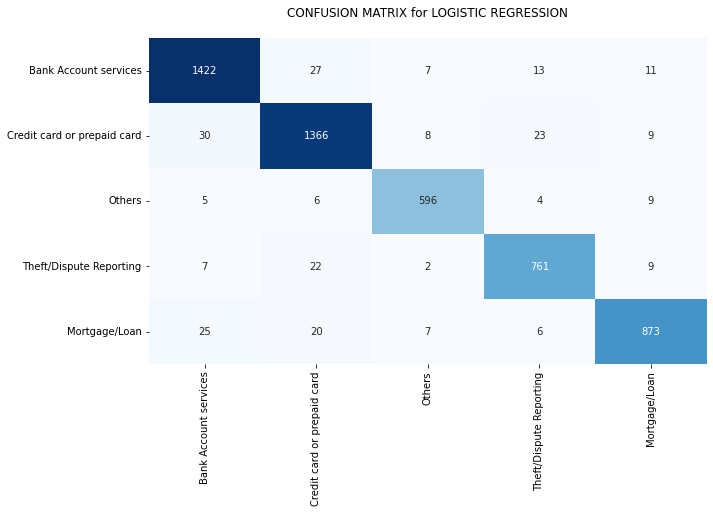

In [ ]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, model_name)

In [ ]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score (untuned)': round(f1_lr, 2), 'F1 Score (tuned)': round(f1_lr_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.95


### Model 2: Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Run Decision Tree on default hyperparameters
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
%time 
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [ ]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7896751200351267

In [ ]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_leaf=15, max_features=None)
%time 
clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.8068169575852119

CLASSIFICATION REPORT for DECISION TREE
 
                             precision    recall  f1-score   support

      Bank Account services       0.84      0.82      0.83      1480
Credit card or prepaid card       0.78      0.82      0.80      1436
                     Others       0.80      0.74      0.77       620
    Theft/Dispute Reporting       0.77      0.79      0.78       801
              Mortgage/Loan       0.84      0.82      0.83       931

                   accuracy                           0.81      5268
                  macro avg       0.81      0.80      0.80      5268
               weighted avg       0.81      0.81      0.81      5268



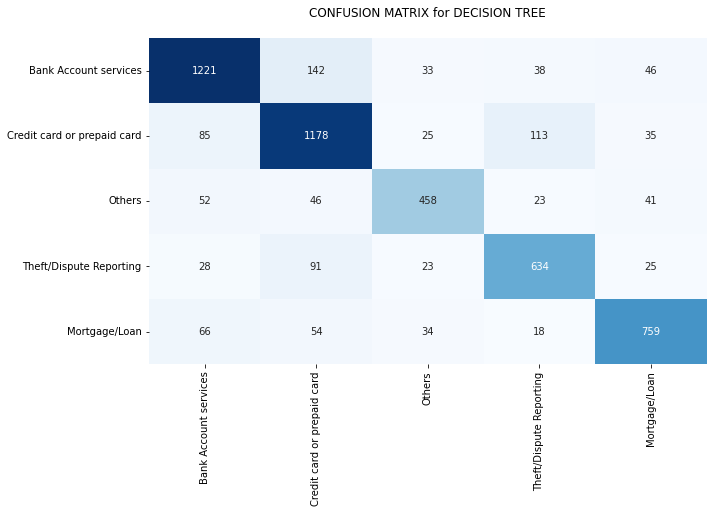

In [ ]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, model_name)

In [ ]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.95
1,Decision Tree,0.79,0.81


### Model 3: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Run the Random Forest model on default hyperparameters
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()
%time 
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.91 µs


In [ ]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8079686447211902

In [ ]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_features=None, max_depth=30, criterion='gini')
%time 
clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [ ]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.8541446454905607

CLASSIFICATION REPORT for RANDOM FOREST
 
                             precision    recall  f1-score   support

      Bank Account services       0.88      0.87      0.88      1480
Credit card or prepaid card       0.84      0.86      0.85      1436
                     Others       0.84      0.82      0.83       620
    Theft/Dispute Reporting       0.85      0.82      0.83       801
              Mortgage/Loan       0.86      0.86      0.86       931

                   accuracy                           0.85      5268
                  macro avg       0.85      0.85      0.85      5268
               weighted avg       0.85      0.85      0.85      5268



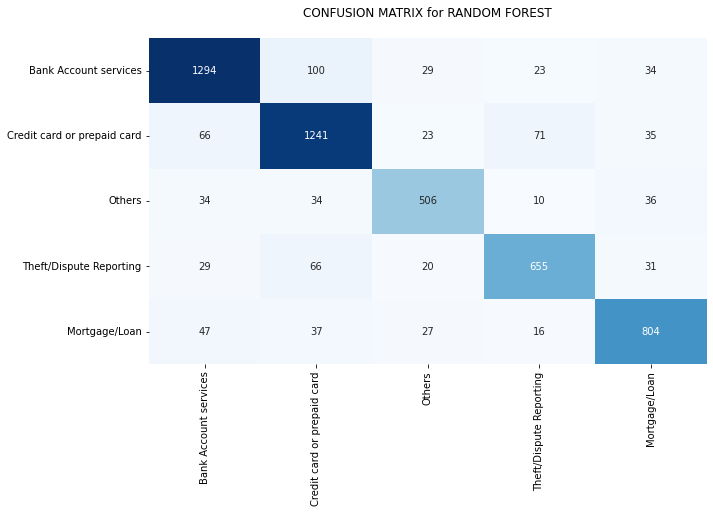

In [ ]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

In [ ]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.95
1,Decision Tree,0.79,0.81
2,Random Forest,0.81,0.85



From the above summary table, we observe that the tuned Logistic Regression performs the best among all that we tried

In [ ]:
# Function to predict a topic for given text
def predict_topic(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = clf_lr_tuned.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [ ]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_new


,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [ ]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_new['predicted topic'] = df_new['complaints'].apply(lambda x: predict_topic([x]))
df_new

,complaints,predicted topic
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,"Yesterday, I received a fraudulent email regar...",Credit card or prepaid card
4,What is the procedure to know my CIBIL score?,Theft/Dispute Reporting
5,I need to know the number of bank branches and...,Bank Account services
